# Setup

In [77]:
# python >= 3.5 version
import sys
assert sys.version_info >= (3,5)

# scikit-learn >= 0.20 is required
import sklearn 
assert sklearn.__version__ >= '0.20'

# tensorflow >=2.0 is required
import tensorflow as tf
assert tf.__version__ >= '2.0'

# import for manipulate data structure
import pandas as pd
import numpy as np
import os

# to make this notebook are stable output accros runs
np.random.seed(42)

#to plot prety figure
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# save the figure automatic
root ='.'
chapter_id = 'RPS'
images_path = os.path.join(root,'images',chapter_id)
os.makedirs(images_path,exist_ok=True)

def save_fig(fig_id,tigh_layout=True,fig_extension='png',resolution=300):
    path = os.path.join(images_path,fig_id+'.'+fig_extension)
    print('save figure',fig_id)
    if tigh_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension,resolution=resolution)


# Data collection

In [78]:
import zipfile
path_local = 'rockpaperscissors.zip'
path_file = zipfile.ZipFile(path_local,'r')
path_file.extractall('/')
path_file.close()


In [79]:
dir_file = "/rockpaperscissors/rps-cv-images"
os.listdir(dir_file)

['paper', 'README_rpc-cv-images.txt', 'rock', 'scissors']

In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
image_generator = ImageDataGenerator(
    #input layers untuk rescaling gambar 255 byte
    shear_range=0.2,
    fill_mode = 'wrap',
    horizontal_flip = True,
    rotation_range = 20,
    validation_split = 0.2
)

In [81]:
train = image_generator.flow_from_directory(
    dir_file,
    target_size=(100,150),
    shuffle=True,
    class_mode='sparse',
    subset='training'
)
validation = image_generator.flow_from_directory(
    dir_file,
    target_size=(100,150),
    class_mode='sparse',
    subset='validation'
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [82]:
train.class_mode

'sparse'

In [83]:
img_height = 100
img_width = 150
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    dir_file,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2188 files belonging to 3 classes.
Using 1751 files for training.


In [84]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dir_file,
    validation_split =0.2,
    subset='validation',
    seed=42,
    image_size = (img_height,img_width),
    batch_size=batch_size
)

Found 2188 files belonging to 3 classes.
Using 437 files for validation.


In [85]:
train_ds.class_names

['paper', 'rock', 'scissors']

# ANN Arsitecture

In [86]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential 
from tensorflow import keras

# Fowrward Pass

In [87]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [88]:
model  = Sequential([
    #layers conversi sebuah bentuk menjadi 2d
    # setiap layers jumlah progetron exponenial dengan jumlah TLU 3
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
     
    layers.Conv2D(16,(3,3),padding='same',activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(32,(3,3),padding='same',activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64,(3,3),padding='same',activation='relu'),
    layers.MaxPooling2D(2,2),
    
    # preprocesing data to 1D, default 28x28
    layers.Flatten(),
    # make hidden layers to computation sebuah classifier per predict proba setiap instance terhadap satu label num_class=>3
    layers.Dense(512,activation='relu'),
    layers.Dense(len(train_ds.class_names),activation='softmax')#multiclass
])

# Compile mode (Backward pass)

In [89]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [90]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
expon_lr = ExponentialLearningRate(factor=1.005)

In [91]:
history = model.fit(train, epochs=1,
                    validation_data=validation,
                    callbacks=[expon_lr])

55/55 [==============================] - 20s 367ms/step - loss: 1.0835 - accuracy: 0.4272 - val_loss: 1.0542 - val_accuracy: 0.5515


Text(0, 0.5, 'Loss')

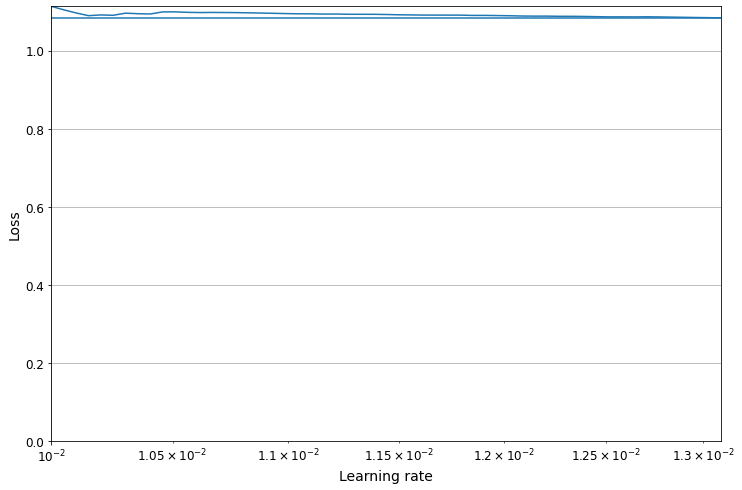

In [92]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
plt.figure(figsize=(12,8))
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [93]:
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2022_08_10-10_12_07'

In [94]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("rbs_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [95]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=1.3e-2),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [96]:
history = model.fit(
      train,
      epochs=20,
      validation_data=validation,
      verbose=2,
      callbacks=[checkpoint_cb,early_stopping_cb,tensorboard_cb]
      )

Epoch 1/20
55/55 - 14s - loss: 1.0000 - accuracy: 0.5374 - val_loss: 0.9127 - val_accuracy: 0.6705 - 14s/epoch - 261ms/step
Epoch 2/20
55/55 - 14s - loss: 0.8546 - accuracy: 0.6248 - val_loss: 0.7097 - val_accuracy: 0.7254 - 14s/epoch - 249ms/step
Epoch 3/20
55/55 - 14s - loss: 0.6833 - accuracy: 0.7190 - val_loss: 0.5333 - val_accuracy: 0.8261 - 14s/epoch - 246ms/step
Epoch 4/20
55/55 - 14s - loss: 0.5540 - accuracy: 0.7933 - val_loss: 0.4814 - val_accuracy: 0.8398 - 14s/epoch - 248ms/step
Epoch 5/20
55/55 - 14s - loss: 0.4670 - accuracy: 0.8361 - val_loss: 0.3689 - val_accuracy: 0.8650 - 14s/epoch - 247ms/step
Epoch 6/20
55/55 - 14s - loss: 0.3688 - accuracy: 0.8681 - val_loss: 0.2667 - val_accuracy: 0.9085 - 14s/epoch - 248ms/step
Epoch 7/20
55/55 - 14s - loss: 0.2640 - accuracy: 0.9212 - val_loss: 0.2318 - val_accuracy: 0.9153 - 14s/epoch - 246ms/step
Epoch 8/20
55/55 - 14s - loss: 0.2466 - accuracy: 0.9126 - val_loss: 0.2199 - val_accuracy: 0.9359 - 14s/epoch - 246ms/step
Epoch 9/

In [97]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 37, 64)        1

# Rollback the model

In [98]:
model = keras.models.load_model("rbs_model.h5")
eval=model.evaluate(validation)

14/14 [==============================] - 2s 139ms/step - loss: 0.0870 - accuracy: 0.9771


In [99]:
training= model.evaluate(train)

55/55 [==============================] - 8s 140ms/step - loss: 0.0613 - accuracy: 0.9794


1/1 [==============================] - 0s 17ms/step
0.98063993
<PIL.Image.Image image mode=RGB size=150x100 at 0x1AB6DAC3CD0>
rock


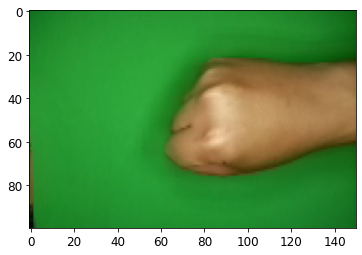

In [121]:
from tensorflow.keras.preprocessing import image
path = 'images\RPS\\testing4.png'
img_path = image.load_img(path,target_size=(100,150))
img_plot = plt.imshow(img_path) 
X = image.img_to_array(img_path)
X = np.expand_dims(X,axis=0)
images = np.vstack([X])
y_pred = model.predict(images, batch_size=10)
print(y_pred[0][1])
print(img_path)
index= np.argmax(y_pred)
if index==0:
    print('paper')
elif index==1:
    print('rock')
elif index==2:
    print('scissors')
else:
    print('unknown')

In [101]:
%load_ext tensorboard
%tensorboard --logdir=./mylogs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 13828), started 0:43:00 ago. (Use '!kill 13828' to kill it.)